* download chrome driver, stable release win-32: http://chromedriver.chromium.org/
* unzip and move it to C:\Windows
* more: https://sites.google.com/a/chromium.org/chromedriver/getting-started

In [1]:
from splinter import Browser
from bs4 import BeautifulSoup
import requests
import re
import time
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import networkx as nx

### testing webdriver
* https://sites.google.com/a/chromium.org/chromedriver/getting-started

In [26]:
from selenium import webdriver

driver = webdriver.Chrome("C:\Windows\chromedriver.exe")  # Optional argument, if not specified will search path.
driver.get('http://www.google.com/xhtml');
time.sleep(5) # Let the user actually see something!
search_box = driver.find_element_by_name('q')
search_box.send_keys('ChromeDriver')
search_box.submit()
time.sleep(5) # Let the user actually see something!
driver.quit()

# testing splinter

In [35]:
req = requests.get("https://www.google.com/")
page = req.text

In [ ]:
soup = BeautifulSoup(page, 'html.parser')
print (soup.prettify())

In [ ]:
executable_path = {'executable_path':r'C:\Windows\chromedriver.exe'}
#browser = Browser('chrome', **executable_path)

In [51]:
with Browser('chrome', **executable_path) as browser:
    # Visit URL
    url = "http://www.google.com"
    browser.visit(url)
    browser.fill('q', 'splinter - python acceptance testing for web applications')
    # Find and click the 'search' button
    button = browser.find_by_name('btnK')
    print(button)
    # Interact with elements
    time.sleep(5) # needs to sleep for the button to become active
    button.click()
    if browser.is_text_present('splinter.readthedocs.io'):
        print("Yes, the official website was found!")
    else:
        print("No, it wasn't found... We need to improve our SEO techniques")

Yes, the official website was found!


# google scholar navigation

In [72]:
req = requests.get("https://scholar.google.com.br/citations?user=vlgs4G4AAAAJ&hl=pt-BR&oi=ao")
page = req.text

In [73]:
soup = BeautifulSoup(page, 'html.parser')
print (soup.prettify())

<!DOCTYPE doctype html>
<html>
 <head>
  <title>
   Jeffrey Heer - Citações do Google Acadêmico
  </title>
  <meta content="text/html;charset=utf-8" http-equiv="Content-Type"/>
  <meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
  <meta content="always" name="referrer"/>
  <meta content="width=device-width,initial-scale=1,minimum-scale=1,maximum-scale=2" name="viewport"/>
  <meta content="telephone=no" name="format-detection"/>
  <link href="/favicon.ico" rel="shortcut icon"/>
  <link href="http://scholar.google.com/citations?user=vlgs4G4AAAAJ&amp;hl=en" rel="canonical"/>
  <style>
   html,body,form,table,div,h1,h2,h3,h4,h5,h6,img,ol,ul,li,button{margin:0;padding:0;border:0;}table{border-collapse:collapse;border-width:0;empty-cells:show;}html,body{height:100%}#gs_top{position:relative;box-sizing:border-box;min-height:100%;min-width:964px;-webkit-tap-highlight-color:rgba(0,0,0,0);}#gs_top>*:not(#x){-webkit-tap-highlight-color:rgba(204,204,204,.5);}.gs_el_ph #gs_top,.gs_el_ta #gs_to

In [642]:
with Browser('chrome', **executable_path) as browser:
    # Visit URL
    url = "https://scholar.google.com.br/"
    browser.visit(url)
    browser.fill('q', 'Jeffrey Heer')
    
    # Find and click the 'search' button
    button = browser.find_by_name('btnG')
    time.sleep(1) # needs to sleep for the button to become active
    button.click()
    
    # Find and click the first link
    button = browser.find_link_by_partial_href('citations?user=')
    time.sleep(1)
    button.click()

    #expand the page
    button = browser.find_by_id('gsc_bpf_more')    
    check_button = browser.evaluate_script('document.getElementById("gsc_bpf_more").disabled')
    while check_button == False:
        time.sleep(1)
        check_button = browser.evaluate_script('document.getElementById("gsc_bpf_more").disabled')
        button.click()
        
    #get html
    result = browser.html

In [274]:
soup = BeautifulSoup(result, 'html.parser')

In [295]:
papers = []
table = soup.find("table", id="gsc_a_t") 
for tr in table.find_all('tr')[2:]:
    for td in tr.find_all("td", {"class": "gsc_a_t"}):
        paper = {}
        paper['title'] = tr.find("a", {"class": "gsc_a_at"}).get_text()
        paper['authors'] = tr.find("div", {"class": "gs_gray"}).get_text().split(',')[:5]
        papers.append(paper)

# part 2

### authors

In [332]:
author_paper = pd.DataFrame(papers, columns=['title', 'authors'])

In [333]:
author_paper.tail()

,title,authors
215,matthewt@ seattleu. edu,"[S Waterson, JI Hong, T Sohn, J Heer, T Ma..."
216,SPECIAL ISSUE DOES BINDING OF SYNESTHETIC COLO...,"[N Sagiv, J Heer, L Robertson]"
217,Evaluating Visualizations to Unearth Behavior ...,[J Heer]
218,VisWeek conference committee,"[M Haley, T Gallemore, M Kingman, D Zemek, ..."
219,The Changing Dynamics of Scientific Collaborat...,"[CR Aragon, J Heer, C Lee, C Silva]"


In [334]:
len(author_paper)

220

In [335]:
authors_table = author_paper.authors.apply(pd.Series).stack(dropna=True).reset_index(drop=True)
authors_table = pd.DataFrame(authors_table)[0].apply(lambda x: x.strip()).unique()
authors_table = pd.DataFrame(authors_table, columns=['author'])
authors_table = authors_table.sort_values('author')

In [336]:
authors_table = authors_table.reset_index().drop('index', axis=1)
authors_table.tail()

,author
258,YS Kim
259,Z Liu
260,Z Qu
261,Ç Demiralp
262,ÇDCE Scheidegger


### papers

In [337]:
papers_table = author_paper['title']

### SQL

In [2]:
sql_db = 'hw1.sqlite'
conn = sqlite3.connect(sql_db)
cur = conn.cursor()

In [3]:
def build_sql_table(dataframe, table_name):   
    try: 
        dataframe.to_sql(table_name, conn, index_label = "id")
    except Exception as error:
        print("\033[91m", error)
        error = str(error)
        if 'already exists' in error:
            user_input = input("Table already exists. Continue? Type 'yes' or 'no' on your keyboard: ")
            if user_input == 'yes': 
                dataframe.to_sql(table_name, conn, index_label = "id", if_exists="replace")
                print('Table',table_name, 'was created on database', sql_db)
            else:
                print('Table was not created')
        pass

In [434]:
build_sql_table(authors_table, 'authors')

In [435]:
build_sql_table(papers_table, 'papers')

In [436]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
cur.fetchall()  

[('authors',), ('papers',)]

### author_paper

In [428]:
author_paper_table = author_paper.authors.apply(pd.Series) \
    .merge(author_paper, left_index = True, right_index = True) \
    .drop(["authors"], axis = 1) \
    .melt(id_vars = ['title'], value_name = "author") \
    .drop("variable", axis = 1) \
    .dropna()

In [430]:
#remove espaçamento nos nomes
author_paper_table = pd.DataFrame(author_paper_table.author.apply(lambda x: x.strip())) \
    .merge(author_paper_table[['title']], left_index = True, right_index = True)

In [431]:
author_paper_table.tail()

,author,title
1087,JJ van Wijk,Symposium Committee
1090,G Chaudhary,VIS Conference Committee
1092,J Kennedy,VIS Conference Committee
1095,T Matthews,matthewt@ seattleu. edu
1098,E Bertini,VisWeek conference committee


In [444]:
author_paper_table.shape

(699, 2)

In [437]:
cur.execute('''CREATE TABLE IF NOT EXISTS author_paper 
               (title_id INT, author_id INT)
               ;''')

In [ ]:
for index, row in author_paper_table.iterrows():
    title = row[1]
    author = row[0]
    
    #print(row[1])
    #print(row[0])
    
    query = 'SELECT id FROM papers WHERE title = "{}"'.format(title)
    cur.execute(query)
    title_id = cur.fetchone()[0]
    query = 'SELECT id FROM authors WHERE author = "{}"'.format(author)
    #print(query)
    cur.execute(query)
    author_id = cur.fetchone()[0]
    
    #print(title_id, author_id)
    query = "INSERT INTO author_paper VALUES ({}, {})".format(title_id,author_id)
    cur.execute(query)
    conn.commit()

# networks

# build networks

### authors

In [4]:
G=nx.Graph()

In [5]:
authors = pd.read_sql_query('SELECT * FROM authors',conn)

In [6]:
labels={}
for index,row in authors.iterrows():
    G.add_node(row[0])
    labels[row[0]]=row[1]

In [7]:
author_paper = pd.read_sql_query('SELECT * FROM author_paper',conn)
author_paper = author_paper.sort_values(by='title_id')

In [8]:
author_paper.head()

,title_id,author_id
0,0,152
419,0,114
220,0,247
420,1,129
221,1,230


In [9]:
graph = list(author_paper.groupby(['title_id'])['author_id'].apply(list))
graph[:5]

[[152, 114, 247], [129, 230, 114], [114, 52], [114, 79], [152, 114]]

In [10]:
for group in graph:
    if len(group)<2: continue
    for i in range(0,len(group)-1):
        for j in range(i+1,len(group)):
            G.add_edge(group[i],group[j])

In [11]:
pos=nx.spring_layout(G, k=0.2, weight=1, iterations=50)

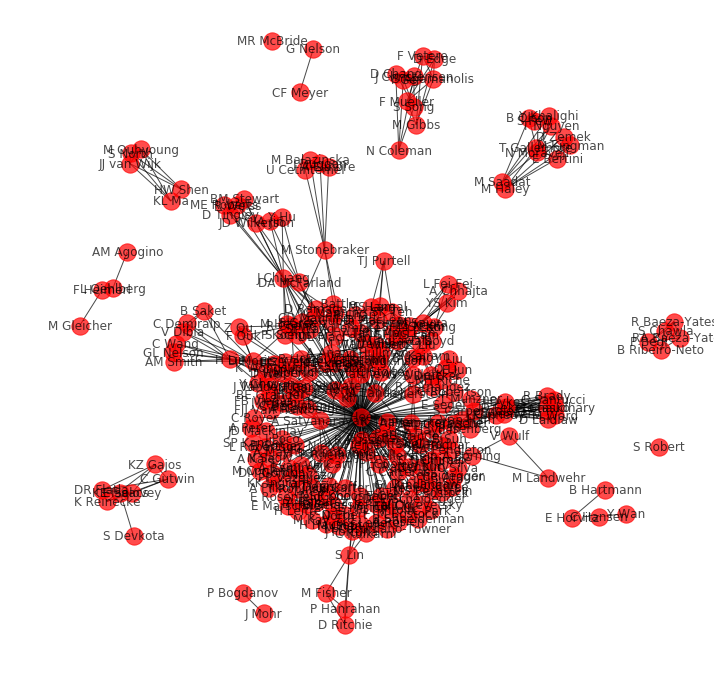

In [13]:
plt.figure(3,figsize=(12,12)) 
nx.draw_networkx(G, pos, labels=labels, alpha=0.7)
plt.axis('off')
#plt.show()
plt.savefig("authors_graph.png")

### papers

In [14]:
G_papers=nx.Graph()

In [15]:
papers = pd.read_sql_query('SELECT * FROM papers',conn)

In [16]:
labels={}
for index,row in papers.iterrows():
    G_papers.add_node(row[0])
    labels[row[0]]=row[1]

In [17]:
author_paper = pd.read_sql_query('SELECT * FROM author_paper',conn)
author_paper = author_paper.sort_values(by='author_id')

In [18]:
author_paper.head()

,title_id,author_id
689,181,0
433,23,0
485,94,0
399,196,1
351,138,1


In [19]:
graph = list(author_paper.groupby(['author_id'])['title_id'].apply(list))
graph[:5]

[[181, 23, 94], [196, 138, 161], [38], [46], [148, 91]]

In [20]:
for group in graph:
    if len(group)<2: continue
    for i in range(0,len(group)-1):
        for j in range(i+1,len(group)):
            G_papers.add_edge(group[i],group[j])

In [21]:
pos=nx.spring_layout(G_papers, k=0.2, weight=1, iterations=50)

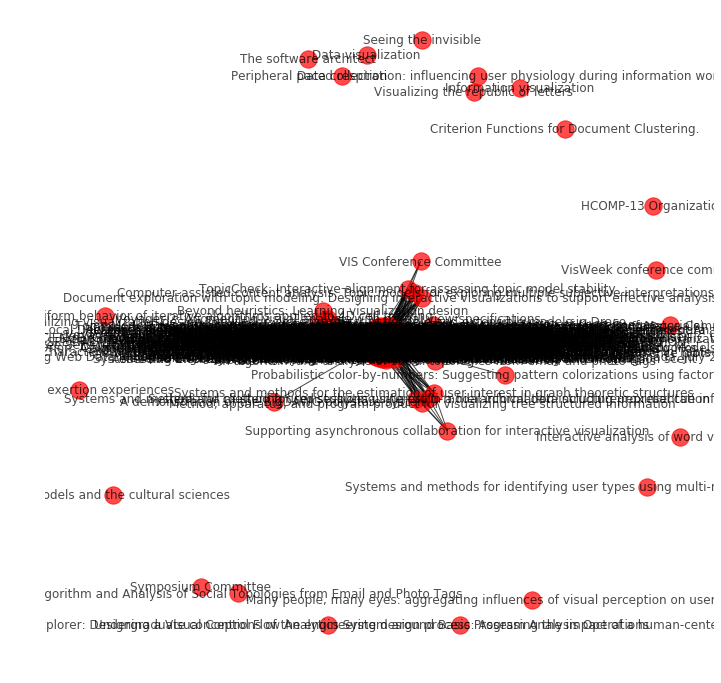

In [22]:
plt.figure(3,figsize=(12,12)) 
nx.draw_networkx(G_papers, pos, labels=labels, alpha=0.7)
plt.axis('off')
plt.savefig("papers_graph.png")

# drafts

In [ ]:
result = result.split('\n')

In [ ]:
re.findall('^\d+ ?\d+$', '2006')

In [157]:
for element in result:
    if element == '*':
        result.remove(element)
    elif len(re.findall('^\d+ ?\d+$', element)) is not 0:
        print(element)
        result.remove(element)

In [173]:
count = 0
papers = []
for element in result[:50]: #must fix extraction
    if count%3 == 0:
        paper = {}
        paper['title'] = element
    if count%3 == 1:
        paper['authors'] = element.split(',')[:5]
        papers.append(paper)
    count += 1

In [161]:
test = '322 2008'
re.findall('^\d+ ?\d+$', test)

['322 2008']

In [378]:
import os

In [380]:
os.getcwd()

'D:\\Dropbox\\A-Marcelo\\education-work\\2017-EMAP\\14-ds\\homeworks\\FDS-Homeworks\\hw1'